In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [6]:
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

,mes,ano,partos_e_nascimentos_qtd
0,1,2009,105424.0
1,1,2010,103943.0
2,1,2011,98951.0
3,1,2012,92914.0
4,1,2013,94223.0
...,...,...,...
177,12,2019,80365.0
178,12,2020,75730.0
179,12,2021,78142.0
180,12,2022,75175.0


In [7]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [8]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [9]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))

In [10]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [11]:
df_st.head()

,partos_e_nascimentos_qtd,partos_e_nascimentos_val,cirurgias_obstetricas_qtd,cirurgias_obstetricas_val
time,,,,
2009-01-01,105424.0,56176411.81,70826.0,34960984.60
2009-02-01,102933.0,54825506.19,69128.0,34439919.89
2009-03-01,117114.0,62399264.22,77726.0,38846455.60
2009-04-01,113382.0,60340947.92,75718.0,37832404.45
2009-05-01,114401.0,61212225.34,76650.0,38719927.20


In [19]:
df_st = df_st['2009-01-01':'2023-12-01']

In [21]:
fig = px.line(df_st, y='partos_e_nascimentos_qtd',title='Números de partos entre 2009 e 2023')
# fig2 = px.line(df_st, y='partos_e_nascimentos_val',title='Valores com partos entre 2009 e 2024')
#fig = make_subplots(rows=2, cols=1, subplot_titles=('Quantidade', 'Valores'), shared_xaxes=True, shared_yaxes=False)

#fig.add_trace(go.Scatter(x=df_st.index, y=df_st['partos_e_nascimentos_qtd'], mode='lines', name='Quantidade'), row=1, col=1)
#fig.add_trace(go.Scatter(x=df_st.index, y=df_st['partos_e_nascimentos_val'], mode='lines', name='Valores'), row=2, col=1)

#fig.update_xaxes(dtick="M1", tickmode='auto', rangeslider_visible=True)
fig.update_layout(template = 'plotly_white')

# fig.update_layout(
#     xaxis2_rangeslider_visible=True,
#     xaxis2_type="date",
#     autosize=True, height=900
#     )
fig.show()

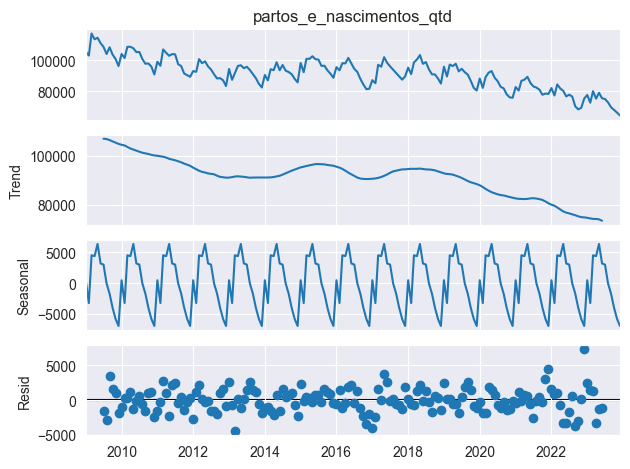

In [23]:
decomposition = seasonal_decompose(df_st['partos_e_nascimentos_qtd'], model='additive')
decomposition.plot()
plt.show()

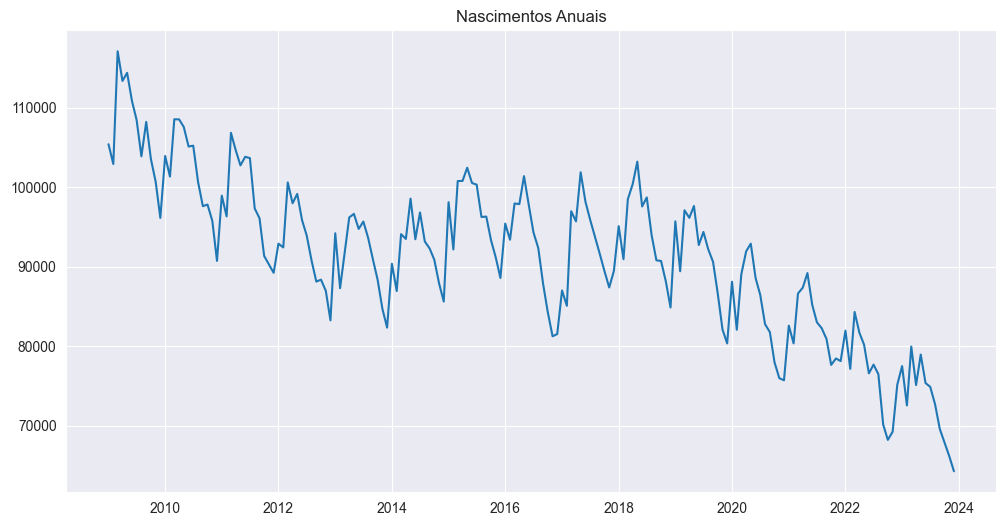

Teste ADF na série original:
ADF Statistic: -0.2014761075527565
p-value: 0.9383454404729212
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
ADF Statistic: -0.2014761075527565
p-value: 0.9383454404729212
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045


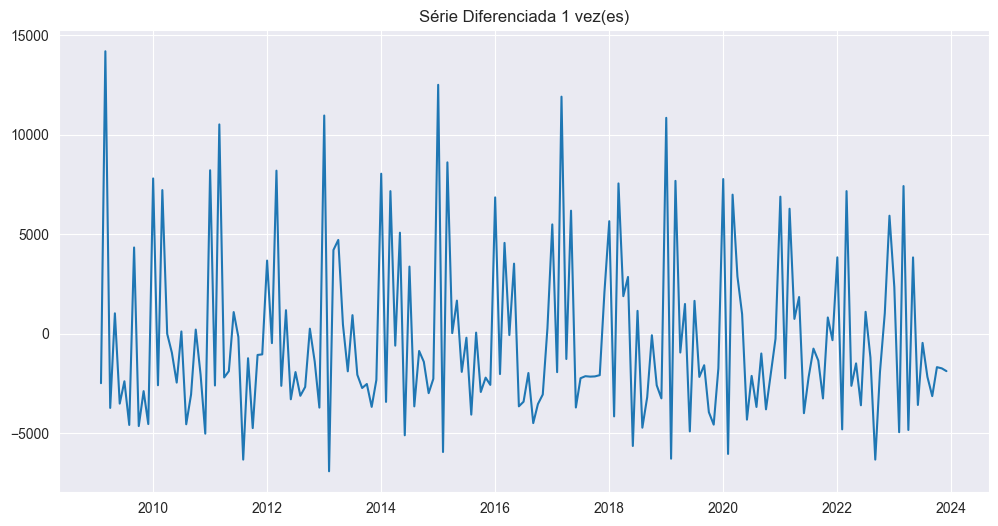

ADF Statistic: -2.859405150517863
p-value: 0.050276374999203836
Critical Values:
   1%: -3.47086589632514
   5%: -2.879330279087651
   10%: -2.57625492712671


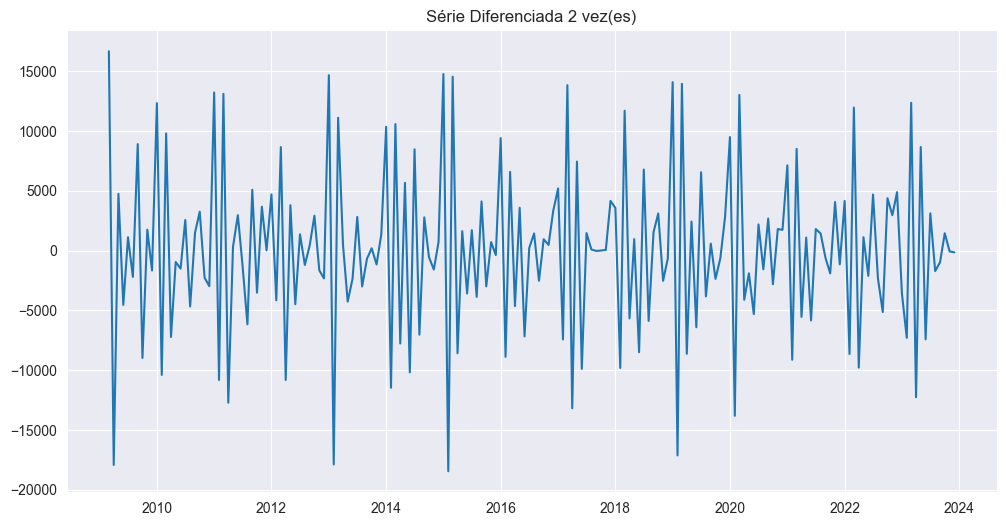

ADF Statistic: -10.240306074953983
p-value: 4.7687243237441935e-18
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
A série se tornou estacionária após 2 diferenciações.


In [15]:
# Função para testar estacionariedade com o teste ADF
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05  # Retorna True se a série é estacionária (p-value <= 0.05)

# Plotar a série temporal original
plt.figure(figsize=(12, 6))
plt.plot(df_st.index, df_st['partos_e_nascimentos_qtd'])
plt.title('Nascimentos Anuais')
plt.show()

# Testar estacionariedade da série original
print('Teste ADF na série original:')
adf_test(df_st['partos_e_nascimentos_qtd'])

# Diferenciação até a série se tornar estacionária
d = 0
serie = df_st['partos_e_nascimentos_qtd']
while not adf_test(serie):
    d += 1
    serie = serie.diff().dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(serie)
    plt.title(f'Série Diferenciada {d} vez(es)')
    plt.show()

print(f'A série se tornou estacionária após {d} diferenciações.')


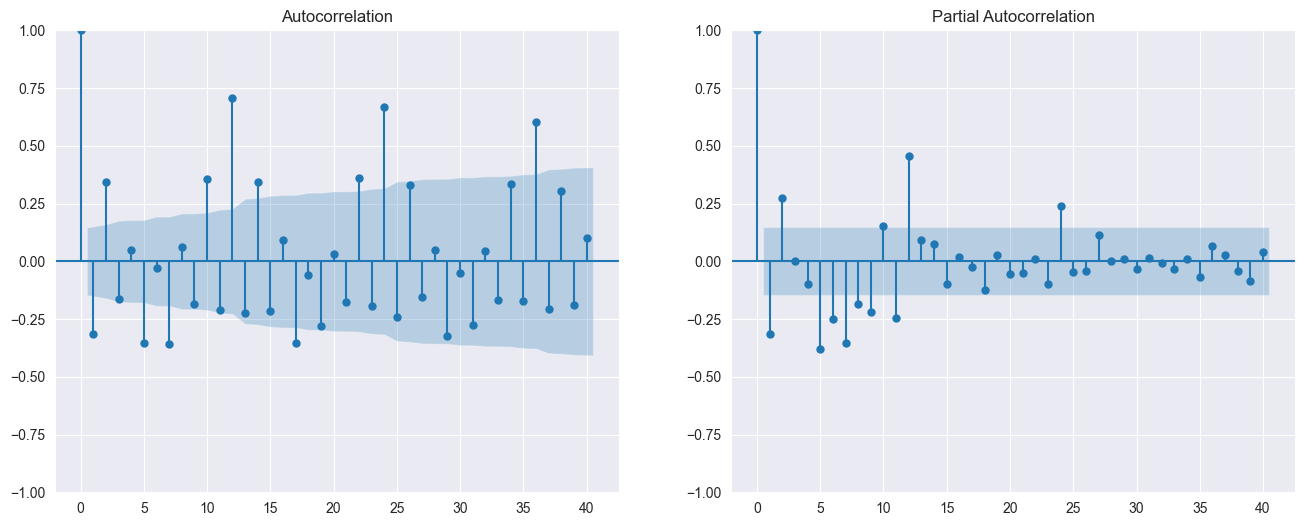

In [16]:
# Plotar ACF e PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_st['partos_e_nascimentos_qtd'].diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_st['partos_e_nascimentos_qtd'].diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [25]:
# Usar auto_arima para encontrar os melhores valores de p, d e q
model = pm.auto_arima(df_st['partos_e_nascimentos_qtd'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3457.038, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3505.685, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3501.437, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3503.454, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3504.203, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3478.250, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3477.614, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3477.501, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3453.809, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3476.896, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3476.273, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3452.430, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3501.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : 

                                  SARIMAX Results                                   
Dep. Variable:     partos_e_nascimentos_qtd   No. Observations:                  180
Model:                       ARIMA(3, 2, 3)   Log Likelihood               -1751.330
Date:                      Wed, 12 Jun 2024   AIC                           3516.661
Time:                              14:21:20   BIC                           3538.933
Sample:                          01-01-2009   HQIC                          3525.693
                               - 12-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5378      0.180     -2.984      0.003      -0.891      -0.185
ar.L2          0.6446      0.115      5.602      0.000       0.419       0.870
ar.L

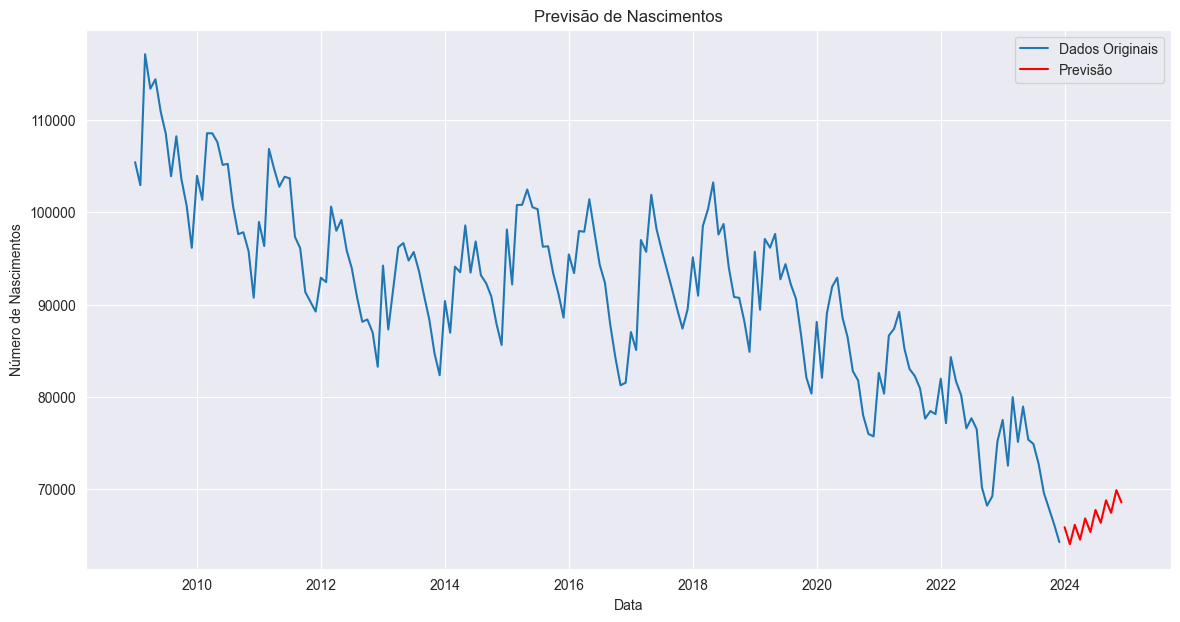

In [18]:
model = ARIMA(df_st['partos_e_nascimentos_qtd'], order=(3, 2, 3))
model_fit = model.fit()
print(model_fit.summary())

# Previsão
forecast = model_fit.forecast(steps=12)
plt.figure(figsize=(14, 7))
plt.plot(df_st.index, df_st['partos_e_nascimentos_qtd'], label='Dados Originais')
plt.plot(forecast.index, forecast, label='Previsão', color='red')
plt.title('Previsão de Nascimentos')
plt.xlabel('Data')
plt.ylabel('Número de Nascimentos')
plt.legend()
plt.show()
